In [372]:
import kagglehub

# download latest version
path = kagglehub.dataset_download("rodolfofigueroa/spotify-12m-songs")
print("Path to dataset files:", path)

Path to dataset files: /Users/cjz/.cache/kagglehub/datasets/rodolfofigueroa/spotify-12m-songs/versions/1


In [373]:
import pandas as pd
import os

cols = ["name", "artists", "key", "mode", "tempo", "year"]
audio_feats = ["energy", "valence", "danceability"]
df = pd.read_csv(os.path.join(path, "tracks_features.csv"), usecols=cols+audio_feats).dropna()

df.describe()

,danceability,energy,key,mode,valence,tempo,year
count,1.204022e+06,1.204022e+06,1.204022e+06,1.204022e+06,1.204022e+06,1.204022e+06,1.204022e+06
mean,4.930560e-01,5.095357e-01,5.194155e+00,6.714595e-01,4.279866e-01,1.176343e+02,2.007328e+03
std,1.896692e-01,2.946840e-01,3.536727e+00,4.696827e-01,2.704845e-01,3.093707e+01,1.210118e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.560000e-01,2.520000e-01,2.000000e+00,0.000000e+00,1.910000e-01,9.405400e+01,2.002000e+03
50%,5.010000e-01,5.240000e-01,5.000000e+00,1.000000e+00,4.030000e-01,1.167260e+02,2.009000e+03
75%,6.330000e-01,7.660000e-01,8.000000e+00,1.000000e+00,6.440000e-01,1.370460e+02,2.015000e+03
max,1.000000e+00,1.000000e+00,1.100000e+01,1.000000e+00,1.000000e+00,2.489340e+02,2.020000e+03


In [360]:
df[audio_feats].corr()

,energy,valence,danceability
energy,1.000000,0.399531,0.283015
valence,0.399531,1.000000,0.563438
danceability,0.283015,0.563438,1.000000


In [379]:
df = df[df["year"] >= 1955]

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1199176 entries, 0 to 1204024
Data columns (total 9 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   name          1199176 non-null  object 
 1   artists       1199176 non-null  object 
 2   danceability  1199176 non-null  float64
 3   energy        1199176 non-null  float64
 4   key           1199176 non-null  int64  
 5   mode          1199176 non-null  int64  
 6   valence       1199176 non-null  float64
 7   tempo         1199176 non-null  float64
 8   year          1199176 non-null  int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 91.5+ MB


In [380]:
# mapping from key(0-11) to Camelot
# 0 = C, 1 = C#, 2 = D, etc... 11 = B
major_map = {0: '8B', 1: '3B', 2: '10B', 3: '5B', 4: '12B', 5: '7B', 
             6: '2B', 7: '9B', 8: '4B', 9: '11B', 10: '6B', 11: '1B'}

minor_map = {0: '5A', 1: '12A', 2: '7A', 3: '2A', 4: '9A', 5: '4A', 
             6: '11A', 7: '6A', 8: '1A', 9: '8A', 10: '3A', 11: '10A'}

# create two helper series
major_col = df["key"].map(major_map)
minor_col = df["key"].map(minor_map)

# pick conditionally between two series based on mode col
df["camelot"] = major_col.where(df["mode"] == 1, minor_col)

df

,name,artists,danceability,energy,key,mode,valence,tempo,year,camelot
0,Testify,['Rage Against The Machine'],0.470,0.978,7,1,0.503,117.906,1999,9B
1,Guerrilla Radio,['Rage Against The Machine'],0.599,0.957,11,1,0.489,103.680,1999,1B
2,Calm Like a Bomb,['Rage Against The Machine'],0.315,0.970,7,1,0.370,149.749,1999,9B
3,Mic Check,['Rage Against The Machine'],0.440,0.967,11,0,0.574,96.752,1999,10A
4,Sleep Now In the Fire,['Rage Against The Machine'],0.426,0.929,2,1,0.539,127.059,1999,10B
...,...,...,...,...,...,...,...,...,...,...
1204020,Gospel of Juke,['FVLCRVM'],0.264,0.966,5,0,0.415,159.586,2014,4A
1204021,Prism Visions,['FVLCRVM'],0.796,0.701,11,0,0.781,121.980,2014,10A
1204022,Tokyo 360,['FVLCRVM'],0.785,0.796,9,0,0.467,121.996,2014,8A
1204023,Yummy!,['FVLCRVM'],0.665,0.856,6,0,0.227,124.986,2014,11A


In [381]:
# dict to store song ids from each camelot
camelot_lookup = df.groupby("camelot").groups

In [382]:
to_int16 = ["tempo", "year"]
to_float32 = [feat for feat in audio_feats if df[feat].dtype == "float64"]

try:
    df[to_int16] = df[to_int16].astype("int16")
    df[to_float32] = df[to_float32].astype("float32")
    df = df.drop(columns=["key", "mode"])
except:
    print("✅ Key and mode already dropped")

print(df.info())
df.head(3).T

<class 'pandas.core.frame.DataFrame'>
Index: 1199176 entries, 0 to 1204024
Data columns (total 8 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   name          1199176 non-null  object 
 1   artists       1199176 non-null  object 
 2   danceability  1199176 non-null  float32
 3   energy        1199176 non-null  float32
 4   valence       1199176 non-null  float32
 5   tempo         1199176 non-null  int16  
 6   year          1199176 non-null  int16  
 7   camelot       1199176 non-null  object 
dtypes: float32(3), int16(2), object(3)
memory usage: 54.9+ MB
None


,0,1,2
name,Testify,Guerrilla Radio,Calm Like a Bomb
artists,['Rage Against The Machine'],['Rage Against The Machine'],['Rage Against The Machine']
danceability,0.47,0.599,0.315
energy,0.978,0.957,0.97
valence,0.503,0.489,0.37
tempo,117,103,149
year,1999,1999,1999
camelot,9B,1B,9B


{'10A': 46989, '10B': 111571, '11A': 29795, '11B': 80264, '12A': 26301, '12B': 48021, '1A': 15490, '1B': 34338, '2A': 11189, '2B': 33575, '3A': 34807, '3B': 69757, '4A': 35338, '4B': 49439, '5A': 29136, '5B': 28254, '6A': 30814, '6B': 41898, '7A': 32523, '7B': 64007, '8A': 52677, '8B': 119722, '9A': 49329, '9B': 123942}


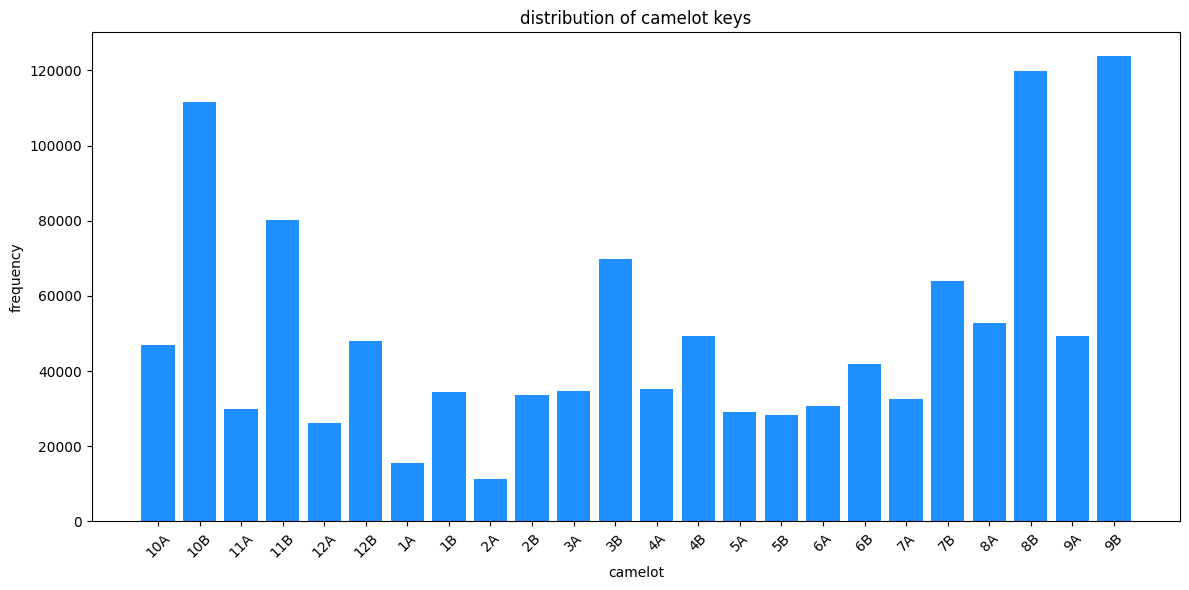

In [383]:
import matplotlib.pyplot as plt

# dictionary storing number of songs in each camelot
sizes = {key: len(camelot_lookup[key]) for key in camelot_lookup}

print(sizes)

plt.figure(figsize=(12,6))
plt.bar(sizes.keys(), sizes.values(), color="dodgerblue")
plt.xlabel("camelot")
plt.xticks(rotation=45)
plt.ylabel("frequency")
plt.title("distribution of camelot keys")
plt.tight_layout()
plt.show()

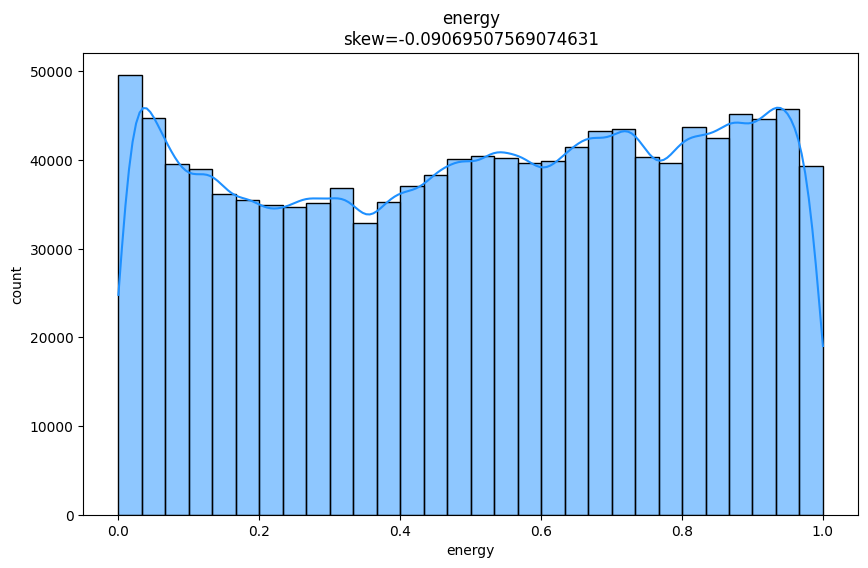

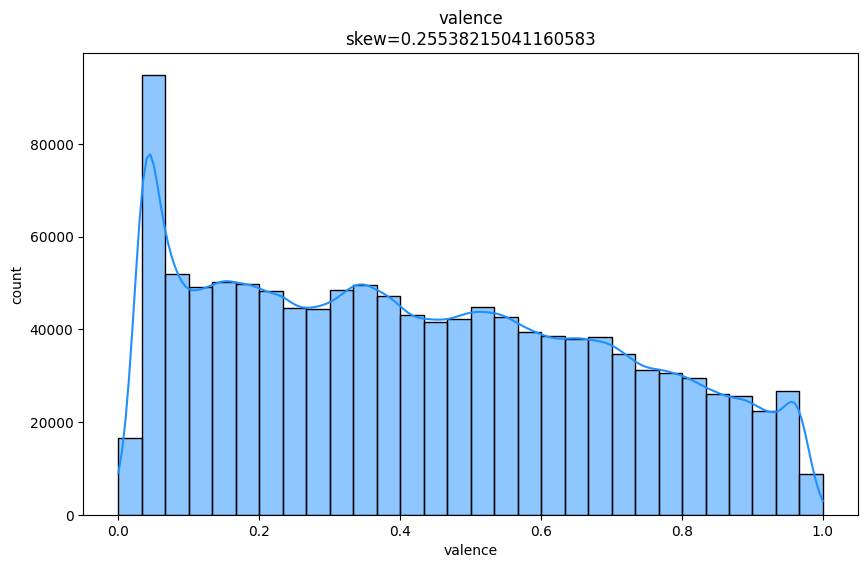

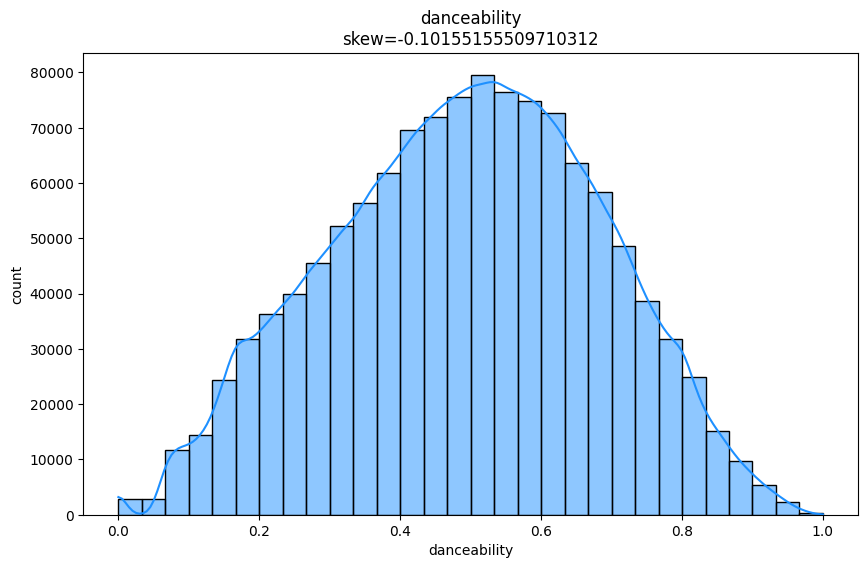

In [384]:
import seaborn as sns
import numpy as np

for feat in audio_feats:
    plt.figure(figsize=(10,6))
    sns.histplot(df[feat], bins=30, kde=True, color="dodgerblue")
    plt.title(f"{feat}\nskew={df[feat].skew()}")
    plt.ylabel("count")
    
    plt.show()

year
2020    69725
2019    67276
2006    56945
2007    56287
2018    56167
        ...  
1963      905
1962      842
1964      729
1960      727
1961      623
Name: count, Length: 61, dtype: int64


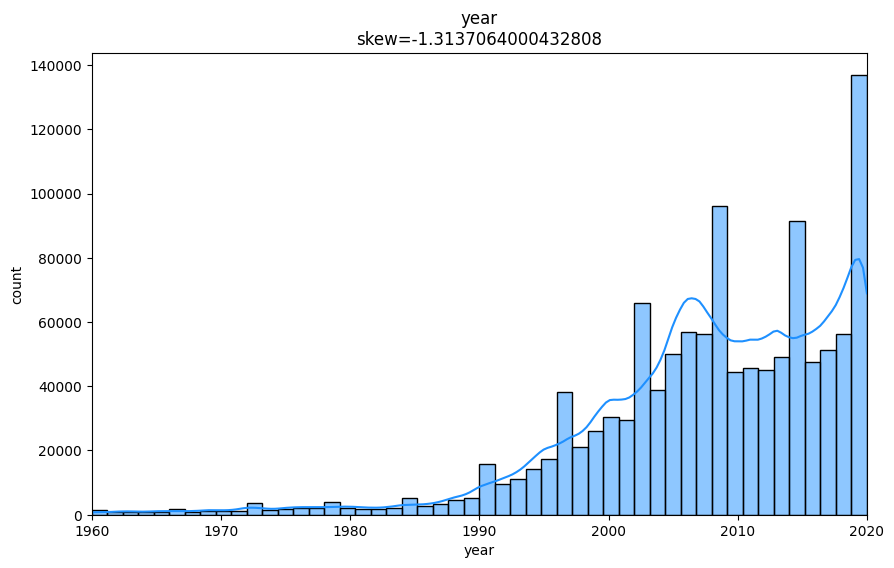

613376
585800


In [391]:
print(df["year"].value_counts())
plt.figure(figsize=(10,6))
plt.xlim(1960, 2020)
sns.histplot(df["year"], bins=50, kde=True, color="dodgerblue")
plt.title(f"{"year"}\nskew={df["year"].skew()}")
plt.ylabel("count")

plt.show()

print(len(df[df["year"] >= 2009]))
print(len(df[df["year"] < 2009]))

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30],
 [Text(0, 0, '1990'),
  Text(1, 0, '1991'),
  Text(2, 0, '1992'),
  Text(3, 0, '1993'),
  Text(4, 0, '1994'),
  Text(5, 0, '1995'),
  Text(6, 0, '1996'),
  Text(7, 0, '1997'),
  Text(8, 0, '1998'),
  Text(9, 0, '1999'),
  Text(10, 0, '2000'),
  Text(11, 0, '2001'),
  Text(12, 0, '2002'),
  Text(13, 0, '2003'),
  Text(14, 0, '2004'),
  Text(15, 0, '2005'),
  Text(16, 0, '2006'),
  Text(17, 0, '2007'),
  Text(18, 0, '2008'),
  Text(19, 0, '2009'),
  Text(20, 0, '2010'),
  Text(21, 0, '2011'),
  Text(22, 0, '2012'),
  Text(23, 0, '2013'),
  Text(24, 0, '2014'),
  Text(25, 0, '2015'),
  Text(26, 0, '2016'),
  Text(27, 0, '2017'),
  Text(28, 0, '2018'),
  Text(29, 0, '2019'),
  Text(30, 0, '2020')])

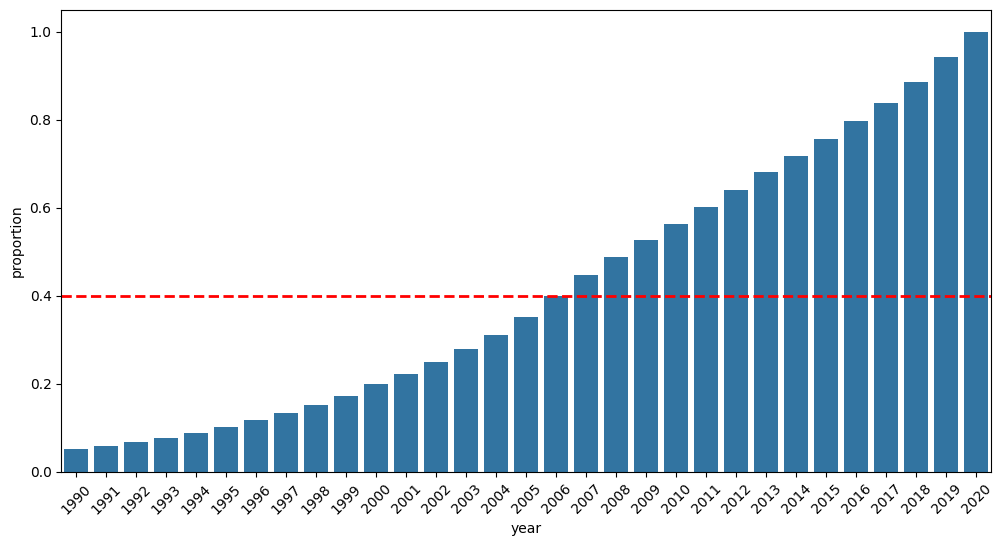

In [427]:
props = df["year"].value_counts(normalize=True).sort_index(ascending=True)
props_before = props.cumsum()

props_before = pd.Series(props_before[30:], index=props.keys()[30:])

plt.figure(figsize=(12,6))
sns.barplot(props_before)
plt.axhline(y=0.4, color='red', linestyle='--', linewidth=2)
plt.xticks(rotation=45)

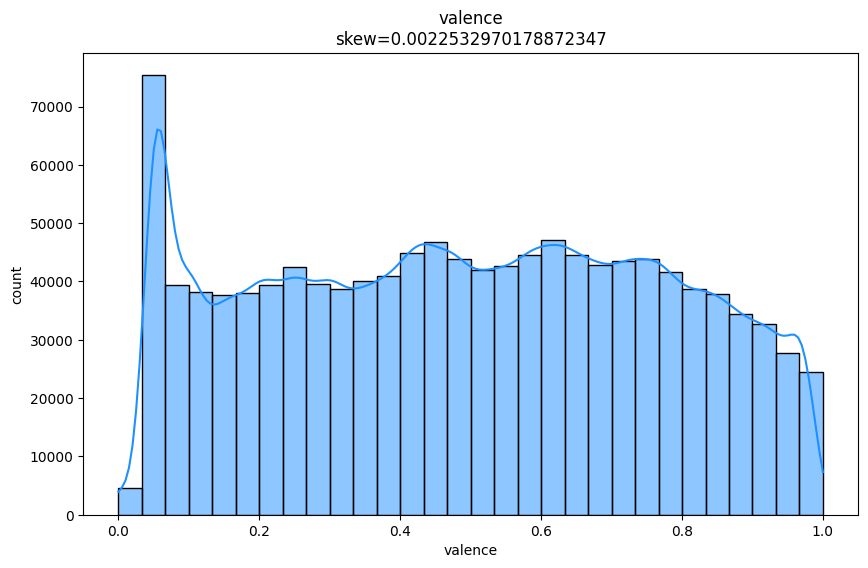

In [428]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, MinMaxScaler

# yeo-johnson stabilizes valence spike, scaler brings it back to range 0-1
vibe_transformer = Pipeline([
    ('power', PowerTransformer(method='yeo-johnson', standardize=True)),
    ('scaler', MinMaxScaler())
])

df['valence'] = vibe_transformer.fit_transform(df[['valence']])

plt.figure(figsize=(10,6))
sns.histplot(df["valence"], bins=30, kde=True, color="dodgerblue")
plt.title(f"{"valence"}\nskew={df["valence"].skew()}")
plt.ylabel("count")

plt.show()

In [429]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1199176 entries, 0 to 1204024
Data columns (total 8 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   name          1199176 non-null  object 
 1   artists       1199176 non-null  object 
 2   danceability  1199176 non-null  float32
 3   energy        1199176 non-null  float32
 4   valence       1199176 non-null  float32
 5   tempo         1199176 non-null  int16  
 6   year          1199176 non-null  int16  
 7   camelot       1199176 non-null  object 
dtypes: float32(3), int16(2), object(3)
memory usage: 54.9+ MB


In [440]:
def get_harmonic_neighbors(camelot: str) -> list[str]:
    neighbors = []
    key = int(camelot[:-1])
    mode = camelot[-1]
    
    neighbors.append(f"{((key - 2) % 12) + 1}{mode}")
    neighbors.append(f"{(key % 12) + 1}{mode}")
    neighbors.append(f"{key}{mode}")
    other_mode = "A" if mode == "B" else "B"
    neighbors.append(f"{key}{other_mode}")
    
    return neighbors


def get_pool_df(song_idx: int, 
                audio_feats: list = ["energy", "valence", "danceability"],
                time_period: str = "modern") -> list[int]:
    camelot = df.at[song_idx, "camelot"]
    harmonic_neighbors = get_harmonic_neighbors(camelot)
    
    pool_indices = []
    
    for camelot in harmonic_neighbors:
        pool_indices.extend(camelot_lookup[camelot])
        
    curr_df = df.loc[pool_indices, audio_feats + ["tempo"]]
        
    return curr_df

get_harmonic_neighbors("12A")
get_pool_df(4)

,energy,valence,danceability,tempo
0,0.978,0.590532,0.470,117
2,0.970,0.456928,0.315,149
8,0.882,0.506633,0.441,83
10,0.704,0.729900,0.456,140
13,0.779,0.795916,0.457,86
...,...,...,...,...
1203858,0.945,0.267606,0.267,110
1203886,0.841,0.937996,0.657,134
1203960,0.515,0.723817,0.329,134
1204007,0.352,0.362081,0.263,90


In [439]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

def get_hybrid_sim_recs(song_idx: int, audio_feats: list = ["energy", "valence", "danceability"]) -> list[tuple]:
    pool = get_pool_df(song_idx, audio_feats)
    

get_hybrid_sim_recs(1)